In [50]:
import json.decoder

import numpy as np
import pandas as pd
import sklearn as sk
import json as json
import matplotlib

import pickle as pk
import matplotlib.pyplot as plt
from IPython.display import display



print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('json version:', json.__version__)
print('matplotlib version:', matplotlib.__version__)

numpy version: 1.23.3
pandas version: 1.5.0
scikit-learn version: 1.1.2
json version: 2.0.9
matplotlib version: 3.6.0


ExpectedRecipeModel : ['RecipeId','RecipeName','recipeBy','recipeDescribtion','recipePrepareTime','Servings?','recipeIngredients','recipeDirections','Nutritions', 'ImageLink','Rating']
Get the data set and define how you will define the model
Recipe Model : ['recipeId', 'recipeName', 'recipeIngredients', 'recipeDescription', 'recipeRating','recipeAuthor']
RecipeRating : ['recipeId', 'recipeRating' , 'recipeComment']
UserInput :
https://www.youtube.com/watch?v=R64Lh1Qwl_0

In [94]:
pkl_recipes = r"C:\Users\evald\Desktop\Ai minor\dataset\Recipes\archive\ingr_map.pkl"
pkl_recipeObj = pd.read_pickle(pkl_recipes)
PP_recipes = r"C:\Users\evald\Desktop\Ai minor\dataset\Recipes\archive\PP_recipes.csv"
csv_recipes = pd.read_csv(PP_recipes)

# print(csv_recipes.info())
# print(pkl_recipeObj.info())

# Recipe dataSet set up
recipeCollumnName = ['id', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'ingredient_ids']
recipeDataSetFormated = csv_recipes[recipeCollumnName]
recipeMealDF = pd.DataFrame(columns=['id', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'ingredient_ids'],index=['1','2','3','4','5'], data=recipeDataSetFormated)
print(recipeDataSetFormated.info)

# Recipe map dataSet set up
# Possibly will need to refference both because an ingredient can have other type

recipeMappingCollumnName = ['processed','replaced','id']
recipeMapDataSetFormated = pkl_recipeObj[recipeMappingCollumnName]
recipeIngredientsDF = pd.DataFrame(recipeMapDataSetFormated,columns=['processed','replaced','id'],index=['1','2','3'])
# recipeMapColumns = {pkl_recipeObj.columns(recipeMappingCollumnName)}
recipeMapColumns = recipeMapDataSetFormated.columns

# decripting the tokenized values


<bound method DataFrame.info of             id                                        name_tokens  \
0       424415  [40480, 37229, 2911, 1019, 249, 6878, 6878, 28...   
1       146223       [40480, 18376, 7056, 246, 1531, 2032, 40481]   
2       312329     [40480, 21044, 16954, 8294, 556, 10837, 40481]   
3        74301                       [40480, 10025, 31156, 40481]   
4        76272  [40480, 17841, 252, 782, 2373, 1641, 2373, 252...   
...        ...                                                ...   
178260  323143  [40480, 6444, 1964, 9369, 486, 569, 17551, 40481]   
178261  149114           [40480, 17027, 24715, 974, 11877, 40481]   
178262   34200           [40480, 12187, 11434, 1738, 2627, 40481]   
178263   30618  [40480, 870, 488, 1325, 519, 2220, 2417, 488, ...   
178264  263840                 [40480, 30565, 12316, 1024, 40481]   

                                        ingredient_tokens  \
0       [[2911, 1019, 249, 6878], [1353], [6953], [153...   
1       [[17918],

Index(['processed', 'replaced', 'id'], dtype='object')

In [95]:
print(pkl_recipeObj)

                                                raw_ingr  raw_words  \
0      medium heads bibb or red leaf lettuce, washed,...         13   
1                  mixed baby lettuces and spring greens          6   
2                                   romaine lettuce leaf          3   
3                                   iceberg lettuce leaf          3   
4                                    red romaine lettuce          3   
...                                                  ...        ...   
11654                                           soybeans          1   
11655                                              goose          1   
11656                                             ajwain          1   
11657                                           brinjals          1   
11658                                              khoya          1   

                                               processed  len_proc replaced  \
0      medium heads bibb or red leaf lettuce, washed,...        73  

In [52]:
#Decode Block

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

def strToList(list_l, splitSymbol):
    list_l = list_l.split(splitSymbol)
    temp = list()
    for l in list_l:
        l = l.replace("[",'').replace("]",'').replace("'", '').replace(" ", '')
        temp.append(l)
    return temp

class ingredientsToList(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns
    def fit(self, X):
        return self
    def transform(self, X):
      for column in self.columns:
        X[column] = X[column].apply(lambda x : strToList(x, ','))
      return X

class ingredientsToOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns
    def fit(self, X):
        return self
    def transform(self, X):
        cv = CountVectorizer(analyzer=lambda x: x)
        for column in self.columns:
            test = cv.fit_transform(X[column].to_list())
            test_columns = [x for x in cv.get_feature_names()]
            X = X.join(pd.DataFrame(test.toarray(), columns = test_columns, index = X.index))
            #X = X.join(pd.DataFrame(test.toarray(), index = X.index))
        return X

class nutritionDataIntoCol(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self

    def transform(self, X):
      nutrition_X = pd.DataFrame(X['nutrition'].to_list(), columns = ['calories', 'total fat', 'sugar_nutrition', 'sodium', 'protein', 'saturated fat', 'carbohydrates'], index = X.index)

      nutrition_X_col = nutrition_X.columns
      for col in nutrition_X_col:
        nutrition_X[col] = nutrition_X[col].apply(lambda x: float(x))

      X = X.join(nutrition_X)
      return X

class getFeatureColumns(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        col = list(X.columns)
        for c in ['ingredients', 'nutrition', 'n_steps', 'n_ingredients']:
            col.remove(c)
        return X[col]

In [93]:
recipeDataSetFormated.ingredient_tokens = recipeDataSetFormated['ingredient_tokens'].apply(lambda x: x.replace('[' ,''))

def definedSet():
    listOfElm = []

    for element in recipeMealDF:
        print(element)
    # np.append(listOfElm,element,range.index())
    # listOfElm.append(element)
    # listOfElm.append(strToList(element,','))

    return listOfElm

# elemental = recipeMealDF.id

print(recipeDataSetFormated)
# np.append(listOfElm,element,range.index())
# listOfElm.append(element)
# listOfElm.append(strToList(element,','))




AttributeError: 'float' object has no attribute 'replace'

Decoding for the tokens

In [ ]:

# def convert_bp_encoded_fields(value: str) -> List[int]:
#   return [int(x.strip('[] ')) for x in value.split(',')]
#
# def get_pp_data(path: str) -> pd.DataFrame:
#     tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
#     pp_recipes_df = pd.read_csv(path,
#       converters={
#         "name_tokens" : convert_bp_encoded_fields,
#         "ingredient_tokens" : convert_bp_encoded_fields,
#         "steps_tokens" : convert_bp_encoded_fields,
#          })
#
# tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
# [tokenizer.decode(x) for x in pp_recipes_df['name_tokens'].iloc[:20].values]

I need to make a model specifically for objects probably using the classes with innit that i could make refferences to wanted data set collums
1. Make an outline ingredient model. ( Get unique ingredient count )
2. Make an enumerator with most populat ingredients used in recipes. ( , check the most frequent ingredient names )
3. Make a plot refferencing the most frequent ingredients used.
4. Make a plot refferencing which recipes were used most by users.
5. Merge the recipe id with Map dataset to unbind the tokens (customDataset = pd.merge(DataSet,PickleDataSetCollumnName,on='recipe_id')



replaced
dressing                163
sausage                 154
chile                    99
cake mix                 85
cheddar                  84
tortilla                 82
pickle                   79
lettuce                  42
cream cheese             41
rum                      39
yeast                    38
chicken broth            37
candy bar                37
mozzarella               33
mayonnaise               31
olive oil                29
diced tomato             27
liver                    26
seasoning mix            25
chili sauce              24
artificial sweetener     22
soy sauce                21
scallion                 20
cheese spread            20
tomato sauce             18
Name: id, dtype: int64


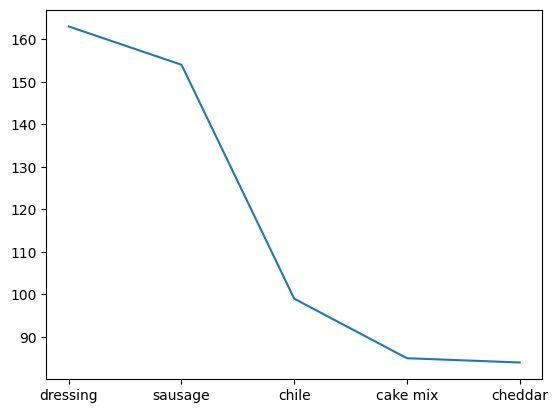

In [97]:
#Task 1 Complete ?
# Get from data set unique ingredients count by getting it from pickle type data set recipeMapDataSetFormated[]

# recipeUniqSet = recipeMapDataSetFormated.pivot_table(index='id',columns='replaced',values=
CollumnNameRec = ['ingredientName','ingredientCount']

recipeUniqSet = recipeMapDataSetFormated.groupby(by=['replaced'])['id'].count().sort_values(ascending=False)

recipeUniqSet = recipeUniqSet.rename([])

matplotlib.pyplot.plot(recipeUniqSet.head(5))
matplotlib.pyplot.scatter(recipeUniqSet['replaced'])

print(recipeUniqSet.head(25))

In [4]:
#Task 2


#
# ingredients = pd.DataFrame({
#             # 'replaced': recipeMapDataSetFormated.groupby('replaced')['id'].count().sort_values(ascending=False),
#             'ingredientCount': recipeMapDataSetFormated.groupby('replaced')['id'].count().sort_values(ascending=False),
#
# })
ingredientsDataSetTest = pd.DataFrame({
            'ingredientName' : recipeMapDataSetFormated['replaced'].nunique,
            'ingredientCount': recipeMapDataSetFormated.groupby('replaced')['id'].count(),

})


# recipeUniqSet = recipeMapDataSetFormated.groupby('replaced')['id'].count().sort_values(ascending=False)

# print(ingredients.head(3))
# ingredients = ingredients.rename_axis("replaced")
# ingredients = ingredients.rename_axis('replaced',axis="columns")
# ingredients = ingredients.index.rename()
# print(ingredients.axes[1].rename("ingredientCount"))
print(ingredientsDataSetTest.head(20))

# matplotlib.pyplot.plot(ingredients.head(5))

# matplotlib.pyplot.scatter(x='replaced',y='ingredientCount')



                                                           ingredientName  \
replaced                                                                    
's baking chocolate     <bound method IndexOpsMixin.nunique of 0      ...   
's chocolate chip       <bound method IndexOpsMixin.nunique of 0      ...   
's hugs chocolate       <bound method IndexOpsMixin.nunique of 0      ...   
's sauce                <bound method IndexOpsMixin.nunique of 0      ...   
's sour cream           <bound method IndexOpsMixin.nunique of 0      ...   
's spicy seasoning      <bound method IndexOpsMixin.nunique of 0      ...   
's syrup                <bound method IndexOpsMixin.nunique of 0      ...   
's teriyaki sauce       <bound method IndexOpsMixin.nunique of 0      ...   
10 bean soup mix        <bound method IndexOpsMixin.nunique of 0      ...   
10-minute success rice  <bound method IndexOpsMixin.nunique of 0      ...   
100 proof vodka         <bound method IndexOpsMixin.nunique of 0      ...   

In [5]:
#Task 3
plt.plot(recipeUniqSet,recipeUniqSet('replaced')['ingredientName'],'ro')
# matplotlib.pyplot.axis([0,6,0,20])
plt.show()

TypeError: 'Series' object is not callable

In [8]:
#Test block
# recipeCollumnName = ['id', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'ingredient_ids']
# recipeDataSetFormated
# recipeDataSetFormated.groupby(
testDataFrame = recipeMapDataSetFormated['ingredient_tokens']

KeyError: 'ingredient_tokens'

('processed', 'replaced', 'id')


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

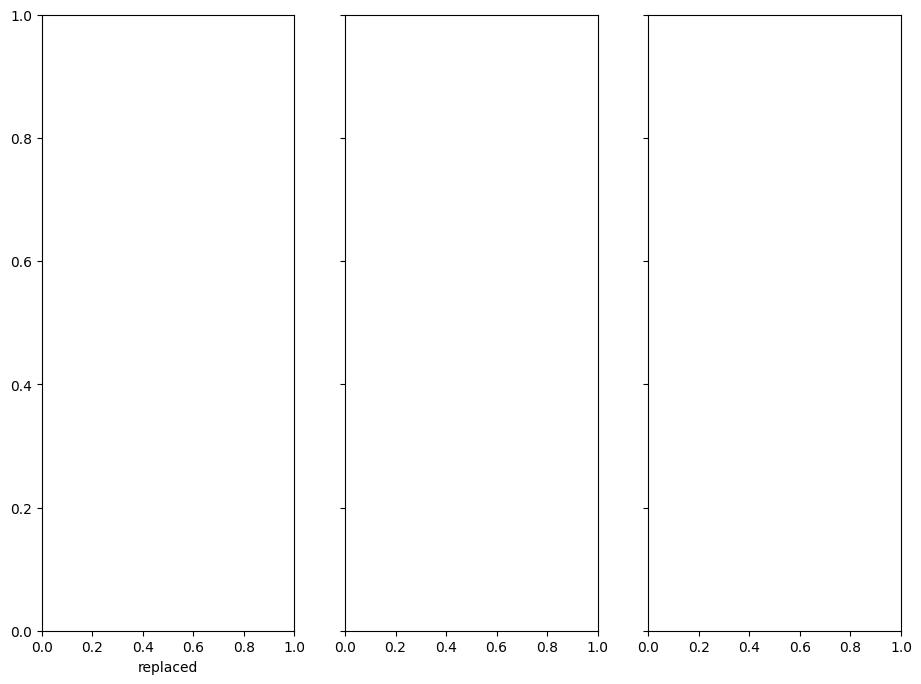

In [11]:
#Box plot
iris_features = tuple(recipeMapDataSetFormated.columns[:4].values)
print(iris_features)

#recipeMapDataSetFormated.boxplot(column=iris_features, by='replaced', figsize=(15,8), layout=(1,4));

In [14]:
#Remove brackets

recipeDataSetFormated.loc['ingredient_tokens'] =  recipeDataSetFormated['ingredient_tokens'].apply(lambda x: x.replace('[',''))

recipeDataSetFormated.loc['ingredient_tokens'] =  recipeDataSetFormated['ingredient_tokens'].apply(lambda x: x.replace(']',''))




C:\Users\evald\AppData\Local\Temp\ipykernel_5976\3141944241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipeDataSetFormated.loc['ingredient_tokens'] =  recipeDataSetFormated['ingredient_tokens'].apply(lambda x: x.replace('[',''))


AttributeError: 'float' object has no attribute 'replace'